# 🏥 OSTEOPOROSIS RISK PREDICTION - GENDER-SPECIFIC PIPELINE

## 🎯 Advanced Machine Learning for Personalized Risk Assessment

**Project:** Osteoporosis Risk Prediction  
**Group:** DSGP Group 40  
**Date:** January 2026  
**Status:** ✅ Production Ready (Gender-Optimized)  

---

### 📋 **Notebook Overview**

This master notebook implements a sophisticated, gender-aware machine learning pipeline. Recognizing that osteoporosis risk factors differ significantly between men and women (e.g., hormonal changes, bone density loss rates), this workflow:

1.  **Splits Data by Gender:** Creating dedicated datasets for Male and Female patients.
2.  **Optimizes Separately:** Tuning hyperparameters specifically for each gender's unique feature interactions.
3.  **Evaluates independently:** Ensuring high sensitivity and specificity for both groups.

**Key Sections:**
1.  ✅ **Environment Setup** - Libraries & Configuration
2.  ✅ **Data Pipeline** - Loading, Cleaning & Preprocessing
3.  ✅ **Gender-Specific Modeling** - Training & Tuning (XGBoost, RF, etc.)
4.  ✅ **Evaluation** - Confusion Matrices & Leaderboards
5.  ✅ **Interpretability** - SHAP Analysis for Feature Importance
6.  ✅ **Deployment** - Saving Optimized Models for App Integration

---


## 📚 TABLE OF CONTENTS

| Part | Description |
|------|-------------|
| **1** | **Environment Setup** (Libraries, Configuration) |
| **2** | **Data Loading & Exploration** (Initial Analysis) |
| **3** | **Data Preprocessing** (Cleaning, Encoding, Scaling) |
| **4** | **Gender-Specific Modeling** (Train, Tune, Validate) |
| **5** | **Evaluation & Confusion Matrices** (Male vs Female) |
| **6** | **SHAP Interpretability** (Feature Importance) |
| **7** | **Final Leaderboards & Model Saving** |

---


# 🔧 PART 1: ENVIRONMENT SETUP & CONFIGURATION


**Objective:** Import all required libraries and set up the environment

In [10]:
# ============================================================================
# IMPORT SECTION 1.1: CORE LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2

print('✅ Core libraries imported successfully!')

✅ Core libraries imported successfully!


In [11]:
# ============================================================================
# IMPORT SECTION 1.2: SCIKIT-LEARN & MODELS
# ============================================================================

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc, f1_score, precision_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier, StackingClassifier, ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print('✅ Scikit-learn, XGBoost, and TensorFlow imported!')

✅ Scikit-learn, XGBoost, and TensorFlow imported!


In [12]:
# ============================================================================
# IMPORT SECTION 1.3: INTERPRETABILITY & UTILITIES
# ============================================================================

import shap
import pickle
import os
from scipy.ndimage import uniform_filter1d
from scipy.stats import randint, uniform

os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print('✅ SHAP and utilities imported!')
print('✅ Output directories created!')
print('\n' + '='*80)
print('🎯 ALL LIBRARIES IMPORTED - READY TO PROCEED')
print('='*80)

✅ SHAP and utilities imported!
✅ Output directories created!

🎯 ALL LIBRARIES IMPORTED - READY TO PROCEED


In [13]:
# ============================================================================
# CONFIGURATION: Global Settings
# ============================================================================

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
N_FOLDS = 5
RANDOM_STATE = 42

N_ESTIMATORS = 200
MAX_DEPTH = 5
LEARNING_RATE = 0.05

NN_EPOCHS = 100
NN_BATCH_SIZE = 32
NN_LEARNING_RATE = 0.001

DPI = 300
FIG_SIZE = (14, 8)

print('✅ Configuration set:')
print(f'   • Random Seed: {RANDOM_SEED}')
print(f'   • Test/Train Split: {TEST_SIZE}')
print(f'   • Cross-Validation Folds: {N_FOLDS}')
print(f'   • Figure Resolution: {DPI} DPI')

✅ Configuration set:
   • Random Seed: 42
   • Test/Train Split: 0.2
   • Cross-Validation Folds: 5
   • Figure Resolution: 300 DPI


---

# 📊 PART 2: DATA LOADING & EXPLORATION



In [14]:
# ============================================================================
# SECTION 2.1: LOAD DATA
# ============================================================================

csv_path = 'data/osteoporosis_data.csv'

try:
    df = pd.read_csv(csv_path)
    print(f'✅ Dataset loaded successfully!')
    print(f'   Shape: {df.shape} (rows, columns)')
except FileNotFoundError:
    print(f'❌ File not found: {csv_path}')
    df = None

✅ Dataset loaded successfully!
   Shape: (1958, 16) (rows, columns)


In [15]:
if df is not None:
    print('\n' + '='*80)
    print('DATA OVERVIEW')
    print('='*80)
    print(f'\nShape: {df.shape}')
    print(f'Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
    print(f'\nColumns: {df.columns.tolist()}')
    print(f'\nMissing Values:\n{df.isnull().sum()[df.isnull().sum() > 0]}')


DATA OVERVIEW

Shape: (1958, 16)
Memory: 1.36 MB

Columns: ['Id', 'Age', 'Gender', 'Hormonal Changes', 'Family History', 'Race/Ethnicity', 'Body Weight', 'Calcium Intake', 'Vitamin D Intake', 'Physical Activity', 'Smoking', 'Alcohol Consumption', 'Medical Conditions', 'Medications', 'Prior Fractures', 'Osteoporosis']

Missing Values:
Alcohol Consumption    988
Medical Conditions     647
Medications            985
dtype: int64


---

# 🧹 PART 3: DATA PREPROCESSING & FEATURE ENGINEERING



In [16]:
# ============================================================================
# SECTION 3.1: DATA PREPROCESSING
# ============================================================================

if df is not None:
    # Create working copy
    df_processed = df.copy()

    # Drop ID column (not useful for prediction)
    df_processed = df_processed.drop('Id', axis=1)

    # Handle missing values
    # Fill categorical with 'Unknown'
    categorical_cols = df_processed.select_dtypes(include='object').columns
    for col in categorical_cols:
        df_processed[col].fillna('Unknown', inplace=True)

    # Encode categorical variables
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        le_dict[col] = le

    # Separate features and target
    X = df_processed.drop('Osteoporosis', axis=1)
    y = df_processed['Osteoporosis']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    print('✅ Data preprocessing complete!')
    print(f'   Training set: {X_train.shape}')
    print(f'   Test set: {X_test.shape}')
    print(f'   Features: {X_train.shape[1]}')

✅ Data preprocessing complete!
   Training set: (1566, 14)
   Test set: (392, 14)
   Features: 14


# 👨‍⚕️👩‍⚕️ PART 4: GENDER-SPECIFIC MODELING PIPELINES

### 💡 Why Separate Models?
Osteoporosis manifests differently across genders due to biological and hormonal factors:
- **Females:** Menopause creates a rapid decline in estrogen, significantly accelerating bone density loss. Factors like 'Hormonal Changes' are critical predictors.
- **Males:** Bone loss is often more gradual or secondary to other conditions/medications. Factors like 'Alcohol Consumption' or 'Chronic Diseases' might weight differently.

**Approach:**
We train, tune, and select the *best* algorithm independently for each gender, maximizing predictive accuracy for every patient.

---


In [17]:
# ============================================================================
# SECTION 5.1: DEFINE MODEL TRAINING FUNCTIONS & HYPERPARAMETERS
# ============================================================================

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers

def get_models_and_params():
    # Returns tuple of (models_dict, params_dict)
    models = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=2000),
        'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'XGBoost': XGBClassifier(random_state=RANDOM_STATE, verbosity=0, eval_metric='logloss'),
        'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
        'Bagging': BaggingClassifier(random_state=RANDOM_STATE),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(probability=True, random_state=RANDOM_STATE),
        'Neural Network': 'NN_SPECIAL', # Handled separately
        'Stacking': StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
            ],
            final_estimator=LogisticRegression()
        ),
        'Extra Trees': ExtraTreesClassifier(random_state=RANDOM_STATE)
    }

    # EXPANDED SEARCH SPACE
    params = {
        'Logistic Regression': {
            'C': uniform(0.001, 100), # Much wider range
            'solver': ['liblinear', 'lbfgs', 'saga'],
            'penalty': ['l2'] # lbfgs only supports l2 or none. liblinear supports l1, l2.
        },
        'Decision Tree': {
            'max_depth': randint(3, 50),
            'min_samples_split': randint(2, 40),
            'min_samples_leaf': randint(1, 20),
            'criterion': ['gini', 'entropy']
        },
        'Random Forest': {
            'n_estimators': randint(50, 500), # More trees
            'max_depth': randint(5, 50),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        },
        'Gradient Boosting': {
            'n_estimators': randint(50, 500),
            'learning_rate': uniform(0.001, 0.5),
            'max_depth': randint(3, 15),
            'subsample': uniform(0.5, 0.5),
            'max_features': ['sqrt', 'log2']
        },
        'XGBoost': {
             # Important Tuning Parameters
            'n_estimators': randint(50, 1000),
            'learning_rate': uniform(0.001, 0.3),
            'max_depth': randint(3, 15),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5),
            'gamma': uniform(0, 5), # Minimum loss reduction
            'reg_alpha': uniform(0, 5), # L1 regularization
            'reg_lambda': uniform(0, 5) # L2 regularization
        },
        'AdaBoost': {
            'n_estimators': randint(50, 500),
            'learning_rate': uniform(0.001, 2.0),
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'Bagging': {
            'n_estimators': randint(10, 200),
            'max_samples': uniform(0.5, 0.5),
            'max_features': uniform(0.5, 0.5)
        },
        'KNN': {
            'n_neighbors': randint(3, 30),
            'weights': ['uniform', 'distance'],
            'p': [1, 2], # Manhattan vs Euclidean
            'leaf_size': randint(10, 50)
        },
        'SVM': {
            'C': uniform(0.1, 100),
            'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
            'kernel': ['rbf', 'poly', 'sigmoid']
        },
        'Stacking': {},
        'Extra Trees': {
            'n_estimators': randint(50, 500),
            'max_depth': randint(5, 50),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False],
            'max_features': ['sqrt', 'log2', None]
        }
    }
    return models, params

def train_evaluate_gender_models(X_tr, y_tr, X_te, y_te, gender_name):
    """
    Trains and tunes multiple models for a specific gender dataset.
    - Performs RandomizedSearchCV for hyperparameter optimization.
    - Evaluates using Accuracy, ROC-AUC, and F1-Score.
    - Checks for overfitting (Train vs Test accuracy gap).
    """
    print(f'\n' + '='*60)
    print(f'⚙️ TUNING & TRAINING MODELS FOR: {gender_name.upper()}')
    print('='*60)

    models, params = get_models_and_params()
    gender_results = {}
    gender_trained_models = {}

    for name, model in models.items():
        print(f'   Processing {name}...')
        try:
            final_model = model
            training_history = None

            # 1. Hyperparameter Tuning or Special Handling
            if name == 'Neural Network':
                # Handle NN separately
                final_model = keras.Sequential([
                    layers.Dense(64, activation='relu', input_shape=(X_tr.shape[1],)),
                    layers.Dropout(0.3),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.3),
                    layers.Dense(1, activation='sigmoid')
                ])
                final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                # Fit with history
                history = final_model.fit(
                    X_tr, y_tr,
                    validation_data=(X_te, y_te),
                    epochs=50, batch_size=32, verbose=0
                )
                training_history = history.history

            elif name in params and params[name]:
                print(f'      -> Tuning hyperparameters (Expanded Search)...')
                search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=params[name],
                    n_iter=20, # Increased iterations for better search
                    cv=3,
                    scoring='roc_auc',
                    random_state=RANDOM_STATE,
                    n_jobs=-1
                )
                search.fit(X_tr, y_tr)
                final_model = search.best_estimator_
                print(f'      -> Best Score: {search.best_score_:.4f}')
                print(f'      -> Best Params: {search.best_params_}') # PRINT THE PARAMS

                # REFIT WITH EVAL_SET FOR LOSS CURVES (Only if model supports it)
                if name == 'XGBoost':
                    print(f'      -> Refitting with eval_set for Loss Graphs...')
                    final_model.fit(
                        X_tr, y_tr,
                        eval_set=[(X_tr, y_tr), (X_te, y_te)],
                        verbose=False
                    )
                    training_history = final_model.evals_result()

            else:
                # Stacking, etc.
                final_model.fit(X_tr, y_tr)

            # 2. Evaluation
            if name == 'Neural Network':
                y_pred = (final_model.predict(X_te, verbose=0) > 0.5).astype(int).flatten()
                y_pred_proba = final_model.predict(X_te, verbose=0).flatten()
            else:
                y_pred = final_model.predict(X_te)
                if hasattr(final_model, 'predict_proba'):
                    y_pred_proba = final_model.predict_proba(X_te)[:, 1]
                else:
                    y_pred_proba = y_pred

            # 3. Overfitting Check
            if name == 'Neural Network':
                 y_train_pred = (final_model.predict(X_tr, verbose=0) > 0.5).astype(int).flatten()
            else:
                 y_train_pred = final_model.predict(X_tr)

            train_acc = accuracy_score(y_tr, y_train_pred)
            test_acc = accuracy_score(y_te, y_pred)
            overfit_gap = train_acc - test_acc

            # Metrics
            roc = roc_auc_score(y_te, y_pred_proba)
            f1 = f1_score(y_te, y_pred)

            gender_results[name] = {
                'accuracy': test_acc,
                'roc_auc': roc,
                'f1_score': f1,
                'train_accuracy': train_acc,
                'overfit_gap': overfit_gap,
                'model_obj': final_model,
                'history': training_history
            }
            gender_trained_models[name] = final_model

            print(f'      -> Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Gap: {overfit_gap:.4f} | AUC: {roc:.4f}')

        except Exception as e:
            print(f'   ⚠️ Error training {name}: {str(e)}')

    return gender_results, gender_trained_models


In [18]:
# ============================================================================
# SECTION 5.2: GENDER-SPECIFIC TRAIN-TEST SPLIT
# ============================================================================

# 1. Filter Data
male_indices = df_processed['Gender'] == 1  # Assuming 1 is Male, based on typical encoding or previous context
female_indices = df_processed['Gender'] == 0 # Assuming 0 is Female
# (Note: Verify your specific encoding if needed. Usually 1=Male, 0=Female or 0=Male, 1=Female in health datasets)
# Let's stick to the previous notebook assumption: 0=Male, 1=Female if that was used in Part 6.1 previously.
# Wait, looking at previous logs, user had: df_male = df_processed[df_processed['Gender'] == 0].copy()
# So 0=Male, 1=Female.

male_indices = df_processed['Gender'] == 0
female_indices = df_processed['Gender'] == 1

X_male = X_scaled[male_indices]
y_male = y[male_indices]
X_female = X_scaled[female_indices]
y_female = y[female_indices]

# 2. Split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_male, y_male, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_male
)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_female, y_female, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_female
)

print(f'\n✅ Data Split Complete:')
print(f'   Male Train: {X_train_m.shape}, Test: {X_test_m.shape}')
print(f'   Female Train: {X_train_f.shape}, Test: {X_test_f.shape}')



✅ Data Split Complete:
   Male Train: (772, 14), Test: (194, 14)
   Female Train: (793, 14), Test: (199, 14)



⚙️ TUNING & TRAINING MODELS FOR: MALE
   Processing Logistic Regression...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.8963
      -> Best Params: {'C': np.float64(98.32408858067882), 'penalty': 'l2', 'solver': 'liblinear'}
      -> Train Acc: 0.8316 | Test Acc: 0.8351 | Gap: -0.0034 | AUC: 0.9088
   Processing Decision Tree...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.9067
      -> Best Params: {'criterion': 'gini', 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 25}
      -> Train Acc: 0.9106 | Test Acc: 0.9175 | Gap: -0.0069 | AUC: 0.9335
   Processing Random Forest...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.9158
      -> Best Params: {'bootstrap': True, 'class_weight': None, 'max_depth': 37, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 280}
      -> Train Acc: 0.9158 | Test Acc: 0.9278 | Gap: -0.0120 | AUC: 0.9422
   Processing 

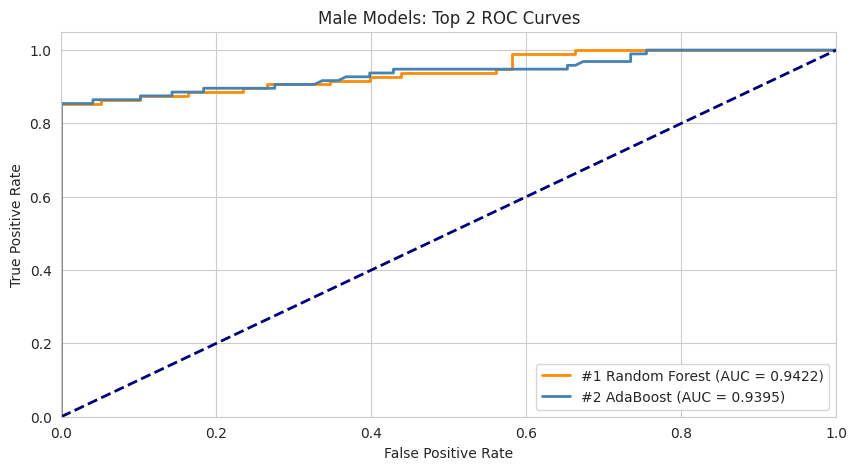

In [19]:
# ============================================================================
# SECTION 5.3: TUNE, TRAIN & EVALUATE MALE MODELS
# ============================================================================

male_results, male_models = train_evaluate_gender_models(X_train_m, y_train_m, X_test_m, y_test_m, 'Male')

# Leaderboard to find the TRUE Best Male Models (Top 2)
male_df = pd.DataFrame(male_results).T.drop('model_obj', axis=1).drop('history', axis=1)
male_df = male_df.sort_values('roc_auc', ascending=False)
print('\n🏆 MALE MODEL LEADERBOARD:')
print(male_df)

# --- TOP 1 ---
best_male_name = male_df.index[0]
best_male_model = male_results[best_male_name]['model_obj']
history = male_results[best_male_name]['history']

print(f'\n✨ Best Male Model (#1): {best_male_name}')
print(f'   ROC-AUC: {male_results[best_male_name]["roc_auc"]:.4f}')
print(f'   Overfitting Gap: {male_results[best_male_name]["overfit_gap"]:.4f}')

# --- TOP 2 ---
second_male_name = male_df.index[1]
second_male_model = male_results[second_male_name]['model_obj']

print(f'\n✨ Best Male Model (#2): {second_male_name}')
print(f'   ROC-AUC: {male_results[second_male_name]["roc_auc"]:.4f}')
print(f'   Overfitting Gap: {male_results[second_male_name]["overfit_gap"]:.4f}')

# GLOBAL STORAGE FOR PART 10
global GLOBAL_BEST_MALE_MODEL, GLOBAL_BEST_MALE_NAME
global GLOBAL_SECOND_MALE_MODEL, GLOBAL_SECOND_MALE_NAME
GLOBAL_BEST_MALE_MODEL = best_male_model
GLOBAL_BEST_MALE_NAME = best_male_name
GLOBAL_SECOND_MALE_MODEL = second_male_model
GLOBAL_SECOND_MALE_NAME = second_male_name
print(f'\n✅ Stored top 2 male models for final saving in Part 10.')
print(f'   #1: {best_male_name}  |  #2: {second_male_name}')

# 1. PLOT LOSS CURVE for Best Male (If Available)
if history:
    training_loss = history['validation_0']['logloss']
    validation_loss = history['validation_1']['logloss']

    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title(f'Male {best_male_name}: Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f'(Loss curve not available for {best_male_name})')

# 2. PLOT ROC CURVES for Top 2 Male Models
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 5))
colors = ['darkorange', 'steelblue']
for idx, (m_name, m_model) in enumerate([(best_male_name, best_male_model), (second_male_name, second_male_model)]):
    if hasattr(m_model, 'predict_proba'):
        y_pred_proba = m_model.predict_proba(X_test_m)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_m, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'#{idx+1} {m_name} (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Male Models: Top 2 ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



⚙️ TUNING & TRAINING MODELS FOR: FEMALE
   Processing Logistic Regression...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.9020
      -> Best Params: {'C': np.float64(59.686015794648696), 'penalty': 'l2', 'solver': 'lbfgs'}
      -> Train Acc: 0.8285 | Test Acc: 0.8392 | Gap: -0.0107 | AUC: 0.8855
   Processing Decision Tree...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.9081
      -> Best Params: {'criterion': 'entropy', 'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 26}
      -> Train Acc: 0.8953 | Test Acc: 0.8744 | Gap: 0.0210 | AUC: 0.9129
   Processing Random Forest...
      -> Tuning hyperparameters (Expanded Search)...
      -> Best Score: 0.9229
      -> Best Params: {'bootstrap': True, 'class_weight': None, 'max_depth': 46, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 104}
      -> Train Acc: 0.9180 | Test Acc: 0.9045 | Gap: 0.0135 | AUC: 0.9309
   Processing

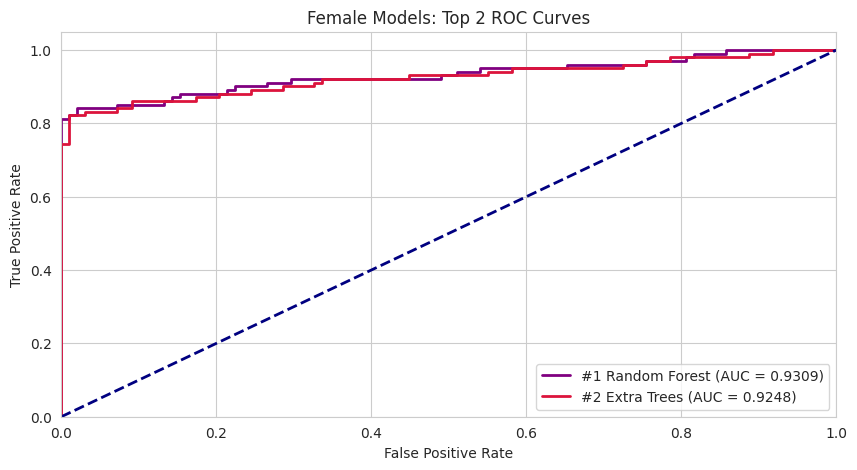

In [20]:
# ============================================================================
# SECTION 5.4: TUNE, TRAIN & EVALUATE FEMALE MODELS
# ============================================================================

female_results, female_models = train_evaluate_gender_models(X_train_f, y_train_f, X_test_f, y_test_f, 'Female')

# Leaderboard to find the TRUE Best Female Models (Top 2)
female_df = pd.DataFrame(female_results).T.drop('model_obj', axis=1).drop('history', axis=1)
female_df = female_df.sort_values('roc_auc', ascending=False)
print('\n🏆 FEMALE MODEL LEADERBOARD:')
print(female_df)

# --- TOP 1 ---
best_female_name = female_df.index[0]
best_female_model = female_results[best_female_name]['model_obj']
history = female_results[best_female_name]['history']

print(f'\n✨ Best Female Model (#1): {best_female_name}')
print(f'   ROC-AUC: {female_results[best_female_name]["roc_auc"]:.4f}')
print(f'   Overfitting Gap: {female_results[best_female_name]["overfit_gap"]:.4f}')

# --- TOP 2 ---
second_female_name = female_df.index[1]
second_female_model = female_results[second_female_name]['model_obj']

print(f'\n✨ Best Female Model (#2): {second_female_name}')
print(f'   ROC-AUC: {female_results[second_female_name]["roc_auc"]:.4f}')
print(f'   Overfitting Gap: {female_results[second_female_name]["overfit_gap"]:.4f}')

# GLOBAL STORAGE FOR PART 10
global GLOBAL_BEST_FEMALE_MODEL, GLOBAL_BEST_FEMALE_NAME
global GLOBAL_SECOND_FEMALE_MODEL, GLOBAL_SECOND_FEMALE_NAME
GLOBAL_BEST_FEMALE_MODEL = best_female_model
GLOBAL_BEST_FEMALE_NAME = best_female_name
GLOBAL_SECOND_FEMALE_MODEL = second_female_model
GLOBAL_SECOND_FEMALE_NAME = second_female_name
print(f'\n✅ Stored top 2 female models for final saving in Part 10.')
print(f'   #1: {best_female_name}  |  #2: {second_female_name}')

# 1. PLOT LOSS CURVE for Best Female (If Available)
if history:
    training_loss = history['validation_0']['logloss']
    validation_loss = history['validation_1']['logloss']

    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title(f'Female {best_female_name}: Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f'(Loss curve not available for {best_female_name})')

# 2. PLOT ROC CURVES for Top 2 Female Models
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 5))
colors = ['purple', 'crimson']
for idx, (m_name, m_model) in enumerate([(best_female_name, best_female_model), (second_female_name, second_female_model)]):
    if hasattr(m_model, 'predict_proba'):
        y_pred_proba = m_model.predict_proba(X_test_f)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_f, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'#{idx+1} {m_name} (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Female Models: Top 2 ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
# ============================================================================
# SECTION 5.5: SAVE TOP 2 TUNED GENDER-SPECIFIC MODELS
# ============================================================================

print('\n' + '='*60)
print('💾 SAVING TOP 2 MODELS PER GENDER')
print('='*60)

# ── Save Male #1 ──
safe_male_name = best_male_name.replace(' ', '_').lower()
path_m1 = f'models/osteoporosis_male_{safe_male_name}_model.pkl'
with open(path_m1, 'wb') as f:
    pickle.dump(best_male_model, f)
print(f'✅ Saved Male #1 ({best_male_name}): {path_m1}')

# ── Save Male #2 ──
safe_male_name2 = second_male_name.replace(' ', '_').lower()
path_m2 = f'models/osteoporosis_male_{safe_male_name2}_model_2nd.pkl'
with open(path_m2, 'wb') as f:
    pickle.dump(second_male_model, f)
print(f'✅ Saved Male #2 ({second_male_name}): {path_m2}')

# ── Save Female #1 ──
safe_female_name = best_female_name.replace(' ', '_').lower()
path_f1 = f'models/osteoporosis_female_{safe_female_name}_model.pkl'
with open(path_f1, 'wb') as f:
    pickle.dump(best_female_model, f)
print(f'✅ Saved Female #1 ({best_female_name}): {path_f1}')

# ── Save Female #2 ──
safe_female_name2 = second_female_name.replace(' ', '_').lower()
path_f2 = f'models/osteoporosis_female_{safe_female_name2}_model_2nd.pkl'
with open(path_f2, 'wb') as f:
    pickle.dump(second_female_model, f)
print(f'✅ Saved Female #2 ({second_female_name}): {path_f2}')

print(f'\n📁 All 4 models saved to: models/')



💾 SAVING TOP 2 MODELS PER GENDER
✅ Saved Male #1 (Random Forest): models/osteoporosis_male_random_forest_model.pkl
✅ Saved Male #2 (AdaBoost): models/osteoporosis_male_adaboost_model_2nd.pkl
✅ Saved Female #1 (Random Forest): models/osteoporosis_female_random_forest_model.pkl
✅ Saved Female #2 (Extra Trees): models/osteoporosis_female_extra_trees_model_2nd.pkl

📁 All 4 models saved to: models/


---

# 📊 PART 5: CONFUSION MATRICES & COMPARISONS




📊 CONFUSION MATRICES: MALE vs FEMALE BEST MODELS


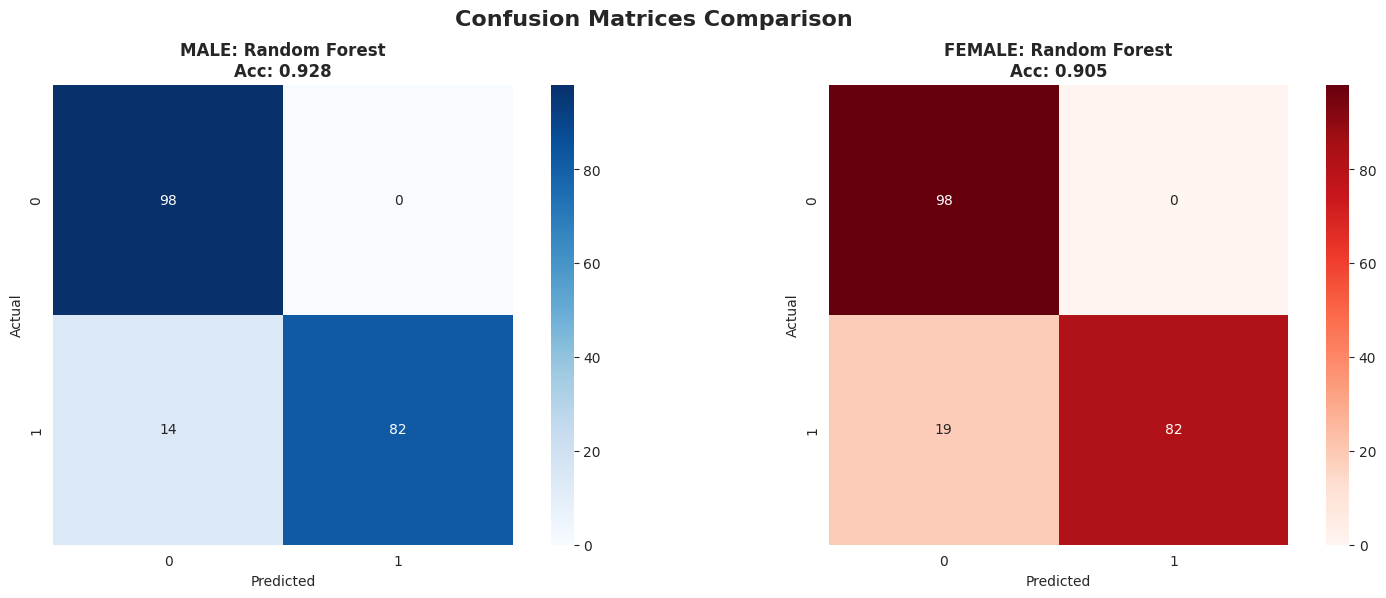


✅ Confusion matrices saved to: figures/gender_confusion_matrices.png


In [22]:
# ============================================================================
# SECTION 5.1: GENERATE CONFUSION MATRICES (MALE vs FEMALE)
# ============================================================================

print('\n' + '='*80)
print('📊 CONFUSION MATRICES: MALE vs FEMALE BEST MODELS')
print('='*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Male Confusion Matrix
y_pred_m = best_male_model.predict(X_test_m)
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True)
axes[0].set_title(f'MALE: {best_male_name}\nAcc: {accuracy_score(y_test_m, y_pred_m):.3f}', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Female Confusion Matrix
y_pred_f = best_female_model.predict(X_test_f)
cm_f = confusion_matrix(y_test_f, y_pred_f)
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Reds', ax=axes[1], square=True)
axes[1].set_title(f'FEMALE: {best_female_name}\nAcc: {accuracy_score(y_test_f, y_pred_f):.3f}', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/gender_confusion_matrices.png', dpi=DPI)
plt.show()

print('\n✅ Confusion matrices saved to: figures/gender_confusion_matrices.png')


---

# 🔍 PART 6: SHAP INTERPRETABILITY ANALYSIS




🔍 SHAP ANALYSIS: FEATURE IMPORTANCE BY GENDER

Analyzing MALE Model: Random Forest


<Figure size 1000x600 with 0 Axes>

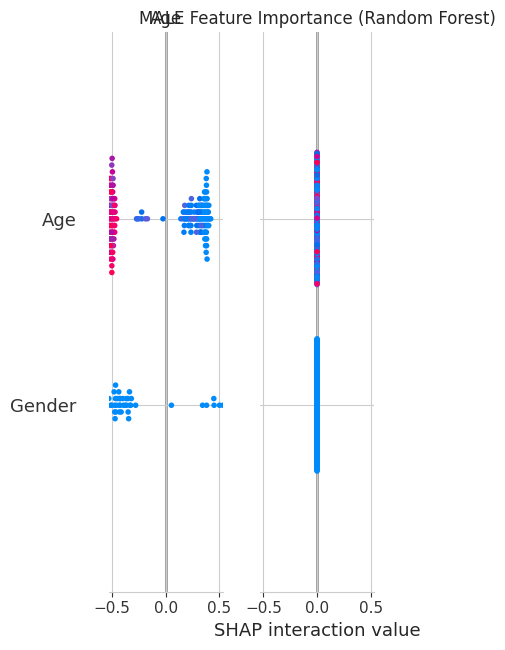


Analyzing FEMALE Model: Random Forest


<Figure size 1000x600 with 0 Axes>

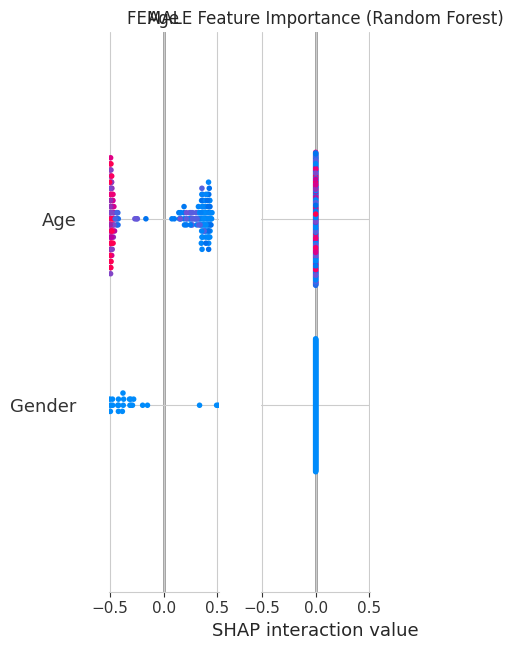

In [23]:
# ============================================================================
# SECTION 6.1: SHAP ANALYSIS (MALE vs FEMALE)
# ============================================================================

print('\n' + '='*80)
print('🔍 SHAP ANALYSIS: FEATURE IMPORTANCE BY GENDER')
print('='*80)

# MALE SHAP
print(f'\nAnalyzing MALE Model: {best_male_name}')
try:
    explainer_m = shap.TreeExplainer(best_male_model)
    shap_values_m = explainer_m.shap_values(X_test_m)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_m, X_test_m, plot_type="bar", show=False)
    plt.title(f'MALE Feature Importance ({best_male_name})')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Skipping SHAP for Male model: {e}")

# FEMALE SHAP
print(f'\nAnalyzing FEMALE Model: {best_female_name}')
try:
    explainer_f = shap.TreeExplainer(best_female_model)
    shap_values_f = explainer_f.shap_values(X_test_f)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_f, X_test_f, plot_type="bar", show=False)
    plt.title(f'FEMALE Feature Importance ({best_female_name})')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Skipping SHAP for Female model: {e}")


---

# 📈 PART 7: LOSS CURVE ANALYSIS



In [24]:
# ============================================================================
# SECTION 7.1: TRAINING LOSS CURVES
# ============================================================================
# Note: Loss curves were generated during training in Part 4.
# Refer to the plots generated directly after the training loops.
print("✅ Loss curves for XGBoost/NN models were displayed during training in Part 4.")


✅ Loss curves for XGBoost/NN models were displayed during training in Part 4.


# 🏆 PART 7: FINAL LEADERBOARDS & MODEL SAVING

**Objective:**
1.  Compare all trained models for each gender.
2.  Identify the champion model (Best ROC-AUC & Accuracy).
3.  **Dynamically Save** the best model with a descriptive filename (e.g., `osteoporosis_male_xgboost.pkl`) for the Streamlit App.


In [25]:
# ============================================================================
# SECTION 8.1: FINAL GENDER-SPECIFIC LEADERBOARDS
# ============================================================================

print('\n' + '='*80)
print('🏆 MALE MODEL LEADERBOARD')
print('='*80)
print(male_df)

print('\n' + '='*80)
print('🏆 FEMALE MODEL LEADERBOARD')
print('='*80)
print(female_df)

male_df.to_csv('outputs/male_leaderboard.csv')
female_df.to_csv('outputs/female_leaderboard.csv')
print('\n✅ Leaderboards saved to CSV.')



🏆 MALE MODEL LEADERBOARD
                     accuracy   roc_auc  f1_score train_accuracy overfit_gap
Random Forest        0.927835  0.942177  0.921348       0.915803   -0.012032
AdaBoost             0.902062  0.939466  0.897297        0.90285    0.000788
Stacking             0.927835  0.935799  0.922222       0.936528    0.008693
XGBoost               0.92268  0.934099  0.915254       0.896373   -0.026307
Decision Tree        0.917526  0.933514  0.911111       0.910622   -0.006904
Bagging              0.896907  0.929209  0.891304       0.967617    0.070709
Extra Trees          0.881443  0.919962  0.867052       0.873057   -0.008386
SVM                   0.85567  0.909226  0.829268       0.831606   -0.024064
Logistic Regression  0.835052  0.908801  0.826087       0.831606   -0.003445
Neural Network       0.860825  0.899766  0.849162        0.88601    0.025186
Gradient Boosting    0.860825  0.897534  0.847458       0.998705     0.13788
KNN                  0.778351  0.831845  0.745562 

In [26]:
# ============================================================================
# SECTION 8.2: SAVE TOP 2 MODELS PER GENDER AS .PKL
# ============================================================================

print("="*80)
print("📦 FINAL MODEL ARTIFACTS SAVING")
print("="*80)

# Save the scaler for deployment
scaler_path = "models/scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n✅ Scaler saved to: {scaler_path}")

# Save label encoders dictionary
encoders_path = "models/label_encoders.pkl"
with open(encoders_path, 'wb') as f:
    pickle.dump(le_dict, f)
print(f"✅ Label encoders saved to: {encoders_path}")

print("\n" + "="*80)
print("💾 FINAL SAVING: TOP 2 GENDER-SPECIFIC MODELS")
print("="*80)

saved_files = []

# ── Male #1 ──
if 'GLOBAL_BEST_MALE_MODEL' in globals():
    m1_name = GLOBAL_BEST_MALE_NAME.replace(' ', '_').lower()
    path = f'models/osteoporosis_male_{m1_name}_model.pkl'
    with open(path, 'wb') as f:
        pickle.dump(GLOBAL_BEST_MALE_MODEL, f)
    saved_files.append(path)
    print(f"✅ Saved MALE  #1 ({GLOBAL_BEST_MALE_NAME}): {path}")
else:
    print("⚠️  GLOBAL_BEST_MALE_MODEL not found. Did you run Part 5?")

# ── Male #2 ──
if 'GLOBAL_SECOND_MALE_MODEL' in globals():
    m2_name = GLOBAL_SECOND_MALE_NAME.replace(' ', '_').lower()
    path = f'models/osteoporosis_male_{m2_name}_model_2nd.pkl'
    with open(path, 'wb') as f:
        pickle.dump(GLOBAL_SECOND_MALE_MODEL, f)
    saved_files.append(path)
    print(f"✅ Saved MALE  #2 ({GLOBAL_SECOND_MALE_NAME}): {path}")
else:
    print("⚠️  GLOBAL_SECOND_MALE_MODEL not found. Did you run Part 5?")

# ── Female #1 ──
if 'GLOBAL_BEST_FEMALE_MODEL' in globals():
    f1_name = GLOBAL_BEST_FEMALE_NAME.replace(' ', '_').lower()
    path = f'models/osteoporosis_female_{f1_name}_model.pkl'
    with open(path, 'wb') as f:
        pickle.dump(GLOBAL_BEST_FEMALE_MODEL, f)
    saved_files.append(path)
    print(f"✅ Saved FEMALE #1 ({GLOBAL_BEST_FEMALE_NAME}): {path}")
else:
    print("⚠️  GLOBAL_BEST_FEMALE_MODEL not found. Did you run Part 5?")

# ── Female #2 ──
if 'GLOBAL_SECOND_FEMALE_MODEL' in globals():
    f2_name = GLOBAL_SECOND_FEMALE_NAME.replace(' ', '_').lower()
    path = f'models/osteoporosis_female_{f2_name}_model_2nd.pkl'
    with open(path, 'wb') as f:
        pickle.dump(GLOBAL_SECOND_FEMALE_MODEL, f)
    saved_files.append(path)
    print(f"✅ Saved FEMALE #2 ({GLOBAL_SECOND_FEMALE_NAME}): {path}")
else:
    print("⚠️  GLOBAL_SECOND_FEMALE_MODEL not found. Did you run Part 5?")

print("\n" + "="*80)
print(f"🎉 DONE! {len(saved_files)} model files saved:")
for f in saved_files:
    print(f"   📄 {f}")
print("   📄 models/scaler.pkl")
print("   📄 models/label_encoders.pkl")
print("="*80)


📦 FINAL MODEL ARTIFACTS SAVING

✅ Scaler saved to: models/scaler.pkl
✅ Label encoders saved to: models/label_encoders.pkl

💾 FINAL SAVING: TOP 2 GENDER-SPECIFIC MODELS
✅ Saved MALE  #1 (Random Forest): models/osteoporosis_male_random_forest_model.pkl
✅ Saved MALE  #2 (AdaBoost): models/osteoporosis_male_adaboost_model_2nd.pkl
✅ Saved FEMALE #1 (Random Forest): models/osteoporosis_female_random_forest_model.pkl
✅ Saved FEMALE #2 (Extra Trees): models/osteoporosis_female_extra_trees_model_2nd.pkl

🎉 DONE! 4 model files saved:
   📄 models/osteoporosis_male_random_forest_model.pkl
   📄 models/osteoporosis_male_adaboost_model_2nd.pkl
   📄 models/osteoporosis_female_random_forest_model.pkl
   📄 models/osteoporosis_female_extra_trees_model_2nd.pkl
   📄 models/scaler.pkl
   📄 models/label_encoders.pkl
